# US Department of Education College Scorecard Data Analysis

#### It is well known that having a college degree of some kind increases your earning potential for the rest of your life by a significant amount. But, are higher tuition costs possibly justified because they're correlated with higher post-graduate earnings? How is the admissions rate of a college related to graduates' earning potential? Are more selective colleges more expensive? To answer these questions, we turn to the US Department of Education's College Scorecard Data.

First, let's import data and necessary packages.

In [1]:
import pandas as pd
import numpy as np
import thinkplot
import thinkstats2
%matplotlib inline

#load 2012-13 and 2014-15 College Scorecard data
cs2012_13 = pd.read_csv('CollegeScorecard_Raw_Data/MERGED2012_13_PP.csv')
cs2014_15 = pd.read_csv('CollegeScorecard_Raw_Data/MERGED2014_15_PP.csv')

#for some odd reason, the first column of the DataFrames, UNITID, can't be accessed with 'UNITID'
#renaming the columns fixes the problem
col_name=cs2012_13.columns[0]
cs2012_13 = cs2012_13.rename(columns = {col_name:'UNITID'})
col_name=cs2014_15.columns[0]
cs2014_15 = cs2014_15.rename(columns = {col_name:'UNITID'})

#print number of rows in each DataFrame to check the number of institutions in each DataFrame
print('Number of colleges in 2012-13 dataset: %i' %(cs2012_13.shape[0] + 1))
print('Number of colleges in 2014-15 dataset: %i' %(cs2014_15.shape[0] + 1))

/home/william/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (1537,1540,1542,1575,1606,1614,1615,1729) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/william/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (6,9,1379,1380,1381,1382,1383,1384,1385,1386,1387,1388,1389,1390,1391,1392,1393,1394,1395,1396,1397,1398,1399,1400,1401,1402,1403,1404,1405,1406,1407,1411,1425,1427,1503,1517,1529,1530,1532,1537,1540,1541,1542,1575,1576,1577,1578,1579,1580,1581,1582,1583,1584,1585,1586,1587,1588,1589,1590,1591,1592,1593,1594,1595,1596,1597,1598,1599,1600,1601,1602,1605,1606,1609,1610,1613,1614,1615,1725,1726,1727,1728,1729) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Number of colleges in 2012-13 dataset: 7794
Number of colleges in 2014-15 dataset: 7704


If we're looking at answering some of these questions as a way to help people make choices between colleges, then we should first filter out institutions that are no longer operating.

Because the 2012-13 dataset contains the mean earnings after graduation data that we're interested in but no data on whether or not schools are operating, we need to match the operating data from the 2014-15 dataset to schools in the 2012-13 dataset.

In [2]:
#loops through schools in the 2014-15 dataset by row index
for i in range(len(cs2014_15.CURROPER)):
    #ensures that the school OPEID exists before using as a reference for data
    if not cs2012_13[cs2012_13['OPEID'] == cs2014_15.OPEID.iloc[i]].empty:
        cs2012_13.set_value(cs2012_13[cs2012_13['OPEID'] == cs2014_15.OPEID.iloc[i]].index[0], "CURROPER", cs2014_15.CURROPER.iloc[i])
    #ensures that the school OPEID6 exists before using as a reference for data
    elif not cs2012_13[cs2012_13['OPEID6'] == cs2014_15.OPEID6.iloc[i]].empty:
        cs2012_13.set_value(cs2012_13[cs2012_13['OPEID6'] == cs2014_15.OPEID6.iloc[i]].index[0], "CURROPER", cs2014_15.CURROPER.iloc[i])
    #ensures that the school UNITID exists before using as a reference for data
    elif not cs2012_13[cs2012_13['UNITID'] == cs2014_15.UNITID.iloc[i]].empty:
        cs2012_13.set_value(cs2012_13[cs2012_13['UNITID'] == cs2014_15.UNITID.iloc[i]].index[0], "CURROPER", cs2014_15.CURROPER.iloc[i])
    #if a school exists in the 2012-13 dataset that doesn't exist in the 2014-15 dataset, it just won't get currently operating data
    #due to the way that we sort for schools that are operating, schools without data are assumed to be no longer operating
        
operating = cs2012_13[cs2012_13.CURROPER == 1]
print('Number of colleges in 2012-13 dataset currently operating: %i' %(operating.shape[0] + 1))

Number of colleges in 2012-13 dataset currently operating: 6438


After filtering for operating institutions, we go from a total list of 7794 institutions to 6438. Some colleges do close, as evidenced by the 90 institution difference between the 2012-13 and 2014-15 dataset. Considering the fact that the College Scorecard contains data for every institution of higher learning in the United States, the yearly churn in institutions shows. That churn, however, definitely does not add up to 1266 institutions, and the way the data is coded in the Scorecard is partially to blame. We match institutions from the 2014-15 dataset to institutions in the 2012-13 dataset using each institution's unique UNITID, OPEID, and OPEID6 numbers. However, from year to year, some institutions' ID numbers change. We try to mitigate this by checking to see if any of the three unique numbers match between the datasets, but sometimes all three numbers for an institution change and it becomes much harder to match the institutions and they get dropped from the dataset.

Because what degree you get from college will significantly impact your earning potential (e.g. a person with a PhD is going to be paid more than someone with a bachelor's degree), we're going to focus on institutions that mainly award bachelor's degrees. Let's select for those institutions.

In [3]:
#select operating institutions that mainly award bachelor's degrees
bachelors = operating[operating.PREDDEG == 3]
print('Number of currently operating colleges in 2012-13 dataset that primarily offer bachelor\'s degrees: %i' %(bachelors.shape[0] +1 ))

Number of currently operating colleges in 2012-13 dataset that primarily offer bachelor's degrees: 1991


After selecting for institutions that primarily award bachelor's degrees, we're down to 1991 colleges. This cuts out a significant number of institutions from our dataset, so we'll revisit adding in colleges that predominantly award associate's degrees later, especially because many institutions that fall into that category, like community colleges, are a common option for college. For now, however, this will be the cleaned, base dataset we will be working from.

Now, we need to consolidate some of the cost data for institutions. The differences between institutions that use an academic year based calendar system and program-based or continuous enrollment calendar systems does not mean much to us, especially when the College Scorecard annualizes cost data for program-based or continuous enrollment calendar system institutions. Because the Scorecard separates out average annual cost of attendance for academic year institutions and program year institutions, we need to combine the data into a single DataFrame column.

In [4]:
#make a copy of our dataset to make it easier to make more data comparisons later on
bachelors_cost = bachelors.copy(deep=True)

for i in range(bachelors_cost.COSTT4_A.shape[0]):
    if np.isnan(bachelors_cost.COSTT4_A.iloc[i]) == False and np.isnan(bachelors_cost.COSTT4_P.iloc[i]) == True:
        bachelors_cost.loc[i, "COST_COMBO"] = bachelors_cost.COSTT4_A.iloc[i]
    if np.isnan(bachelors_cost.COSTT4_A.iloc[i]) == True and np.isnan(bachelors_cost.COSTT4_P.iloc[i]) == False:
        bachelors_cost.loc[i, "COST_COMBO"] = bachelors_cost.COSTT4_P.iloc[i]
    if np.isnan(bachelors_cost.COSTT4_A.iloc[i]) == False and np.isnan(bachelors_cost.COSTT4_P.iloc[i]) == False:
        print("BOTH VALUES EXIST") #makes sure there is no institution with both COSTT4_A and COSTT4_P data

#drop schools that do not have cost data
bachelors_cost = bachelors_cost.dropna(subset=['COST_COMBO'])
print('Colleges in working dataset: %i' %(bachelors_cost.shape[0] + 1))

Colleges in working dataset: 1877


Because not all schools in the dataset have cost data, we're now down to 1877 colleges. To explore the relationship between average cost of attendance and mean earnings after graduation, let's filter out schools that do not have data for graduates' mean earnings 10 years after graduation. Many institutions also don't meet NSLDS and Treasury reporting standards, so their earnings data in the Scorecard is obscured with 'PrivacySuppressed'. Ultimately, that means that we also have to drop those schools from our dataset as well.

In [5]:
#removes schools without earnings data
bachelors_cost_earnings = bachelors_cost[pd.notnull(bachelors_cost['MN_EARN_WNE_P10'])]
#removes schools whose earnings data does not meet NSLDS and Treasury reporting standards
bachelors_cost_earnings = bachelors_cost_earnings[bachelors_cost_earnings.MN_EARN_WNE_P10 != 'PrivacySuppressed']

print('Colleges in working dataset: %i' %(bachelors_cost_earnings.shape[0] + 1))

Colleges in working dataset: 678


We're now down to 678 colleges. Let's see what the relationship between college cost and mean earnings after 10 years looks like. Specifically, we're looking at the relationship between a school's average cost of attendance and that school's students' mean earnings 10 years after graduation.

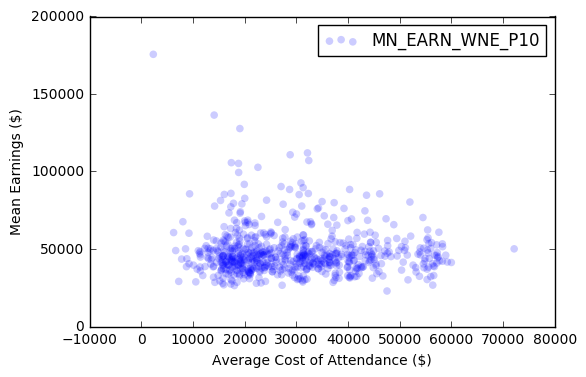

In [6]:
costs = bachelors_cost_earnings.COST_COMBO
earnings = bachelors_cost_earnings.MN_EARN_WNE_P10

thinkplot.Scatter(costs, earnings)
thinkplot.Show(xlabel='Average Cost of Attendance ($)',
               ylabel='Mean Earnings ($)')

To be able to better interpret the data, let's calculate the Spearman Correlation for our data.

In [7]:
thinkstats2.SpearmanCorr(costs, earnings)

0.037708055826214296

We can see here that the mean earnings of an institution's graduates 10 years after graduation is not well correlated with an institution's cost of attendance, especially with a Spearman rank correlation of 0.038.

Since there is no correlation between mean earnings and cost of attendance, let's see if more "exclusive" schools cost more. To do this, let's go back to our dataset filtered out for school's cost data and drop schools that don't have a reported admissions rate.

In [8]:
bachelors_adm = bachelors_cost[pd.notnull(bachelors_cost['ADM_RATE'])]
print('Colleges in working dataset: %i' %(bachelors_adm.shape[0] + 1))

Colleges in working dataset: 623


Dropping those schools leaves us with 623 institutions. Let's graph the data and calculate its Spearman's correlation to see if there is a correlation.

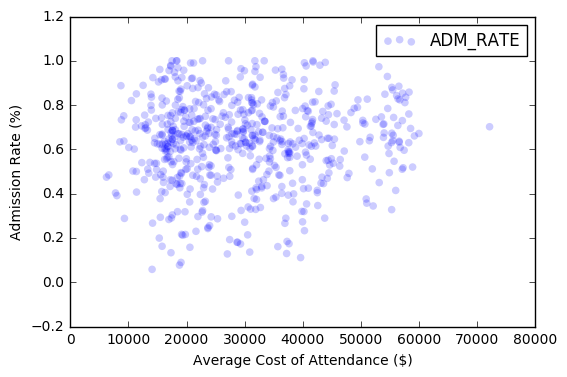

0.044171650099210688

In [9]:
costs = bachelors_adm.COST_COMBO
adm_rate = bachelors_adm.ADM_RATE

thinkplot.Scatter(costs, adm_rate)
thinkplot.Show(xlabel='Average Cost of Attendance ($)',
               ylabel='Admission Rate (%)')

thinkstats2.SpearmanCorr(costs, adm_rate)

With a Spearman's rank correlation of 0.044 and a scatter plot that shows data that is very spread out, it is pretty clear that there is no correlation between a school's admissions rate and a school's average cost of attendance. The data does not seem to suggest that a more "exclusive" school costs more.

With that, let's see if an institution's admissions rate has any bearing on the institution's graduates' earning potential.

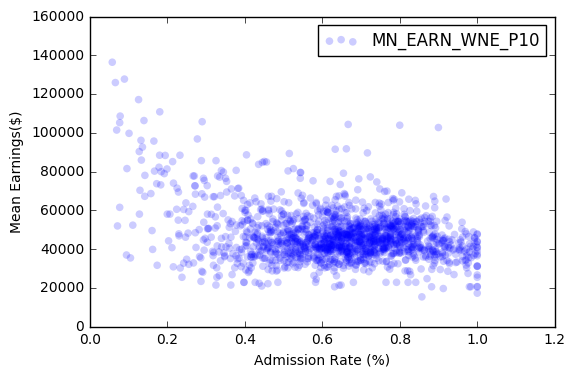

-0.0973158917211535

In [10]:
bachelors_earnings_adm = bachelors[pd.notnull(bachelors['MN_EARN_WNE_P10'])]
bachelors_earnings_adm = bachelors_earnings_adm[bachelors_earnings_adm.MN_EARN_WNE_P10 != 'PrivacySuppressed']
bachelors_earnings_adm = bachelors_earnings_adm[pd.notnull(bachelors_earnings_adm['ADM_RATE'])]

adm_rate = bachelors_earnings_adm.ADM_RATE
earnings = bachelors_earnings_adm.MN_EARN_WNE_P10

thinkplot.Scatter(adm_rate, earnings)
thinkplot.Show(xlabel='Admission Rate (%)', 
               ylabel='Mean Earnings($)')

thinkstats2.SpearmanCorr(adm_rate, earnings)

With a Spearman's rank correlation of -0.097, it would appear as if there is no correlation between an institution's admissions rate and an institution's graduates' mean earnings 10 years after graduation. However, in the scatterplot, it appears as if there are a small number of institutions with very low admissions rates that have graduates that make a significant amount of money 10 years after graduating. There are a number of factors that could potentially support a link between low admissions rates and higher earnings after graduation, but the data as we have analyzed it do not support or refute such a link. If you ignore the outliers on the left of the scatterplot, the vast majority of the data suggest that an institution's exclusivity does not affect its graduates' mean earnings.